In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import torchvision
from torch.utils import data
from torchvision import transforms
from time import time
import multiprocessing as mp

#from torchtoolbox.tools import mixup_data, mixup_criterion

In [2]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 48

        self.conv1 = nn.Conv2d(3, 48, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(48)
        self.layer1 = self._make_layer(block, 48, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 96, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 192, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 384, num_blocks[3], stride=2)
        self.linear = nn.Linear(384, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model():
    return ResNet(BasicBlock, [1, 2, 4, 1])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



In [3]:

class Cutout(object):

    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):

        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):

            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img


def mixup_data(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [4]:
transform_train = torchvision.transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #Cutout(n_holes=1, length=16),  
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=256, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=1000, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [5]:
net = project1_model()

num = count_parameters(net)
print(num)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50) 
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

train_loss_list = []
train_acc_list = []
#train_dur_list = []
test_loss_list = []
test_acc_list = []
#test_dur_list = []



4919674


In [6]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    batch_index = 0
    t0 = time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,1.)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        # loss = nll(outputs, targets)
        
        #loss = criterion(outputs, targets)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        batch_index = batch_idx
        # train_loss += loss.item()
        train_loss = loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a.data).sum().float()
                    + (1 - lam) * predicted.eq(targets_b.data).sum().float())

        #print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     #% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        #print("\n")
    train_loss_list.append(train_loss/(batch_index+1))
    train_acc_list.append(100.*correct/total)
    print(' Train: Loss: %.6f | Acc: %.3f%% | Dur: %.2fS' 
          % (train_loss/(batch_index+1), 100.*correct/total, time() - t0))

def test(epoch):
#     global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    batch_index = 0
    t0 = time()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            # loss = nll(outputs, targets)
            batch_index = batch_idx
            # test_loss += loss.item()
            test_loss = loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            #print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         #% (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            #print("\n")
    test_loss_list.append(test_loss/(batch_index+1))
    test_acc_list.append(100.*correct/total)
    print(' Test:  Loss: %.6f | Acc: %.3f%% | Dur: %.2fS' 
          % (test_loss/(batch_index+1), 100.*correct/total, time() - t0))

    # Save checkpoint.
#     acc = 100.*correct/total
#     if acc > best_acc:
#         print('Saving..')
#         state = {
#             'net': net.state_dict(),
#             'acc': acc,
#             'epoch': epoch,
#             'train_history': (train_loss_list, train_acc_list, test_loss_list, test_acc_list)
#         }
#         if not os.path.isdir('checkpoint'):
#             os.mkdir('checkpoint')
#         torch.save(state, './checkpoint/ckpt_rmsprop.pth')
#         best_acc = acc


def plot_model(train_loss, train_acc, test_loss, test_acc):
    length = len(train_acc)
    plt.subplot(2, 2, 1)
    plt.plot(range(length), train_acc)
    plt.title('Train accuracy vs. epoches')
    plt.ylabel('Train accuracy')
    plt.xlabel('epoch')
    plt.subplot(2, 2, 2)
    plt.plot(range(length), train_loss)
    plt.title('Train loss vs. epoches')
    plt.ylabel('Train loss')
    plt.xlabel('epoch')
    plt.subplot(2, 2, 3)
    plt.plot(range(length), test_acc)
    plt.title('Test accuracy vs. epoches')
    plt.ylabel('Test accuracy')
    plt.xlabel('epoch')
    plt.subplot(2, 2, 4)
    plt.plot(range(length), test_loss)
    plt.title('Test loss vs. epoches')
    plt.ylabel('Test loss')
    plt.xlabel('epoch')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.8)

In [ ]:
for epoch in range(350):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 0
0 196 Loss: 2.327 | Acc: 11.328% (29/256)


1 196 Loss: 1.158 | Acc: 10.156% (52/512)


2 196 Loss: 0.766 | Acc: 10.026% (77/768)


3 196 Loss: 0.569 | Acc: 9.570% (98/1024)


4 196 Loss: 0.450 | Acc: 10.234% (131/1280)


5 196 Loss: 0.366 | Acc: 10.156% (156/1536)


6 196 Loss: 0.322 | Acc: 11.217% (201/1792)


7 196 Loss: 0.277 | Acc: 11.426% (234/2048)


8 196 Loss: 0.239 | Acc: 12.326% (284/2304)


9 196 Loss: 0.220 | Acc: 11.836% (303/2560)


10 196 Loss: 0.192 | Acc: 12.322% (347/2816)


11 196 Loss: 0.177 | Acc: 13.346% (410/3072)


12 196 Loss: 0.172 | Acc: 12.981% (432/3328)




In [ ]:
print(train_acc_list)
print(train_loss_list)

In [9]:
print(test_acc_list)
print(test_loss_list)

[51.87, 62.93, 62.55, 70.58, 74.05, 75.65, 79.42, 83.02, 80.46, 80.4, 83.46, 84.54, 85.02, 85.17, 85.29, 86.0, 85.66, 88.12, 86.51, 87.61, 87.56, 85.83, 87.56, 89.68, 89.56, 88.63, 88.94, 89.1, 90.17, 90.6, 89.82, 90.53, 91.06, 90.8, 90.83, 91.27, 91.32, 90.94, 91.51, 91.44, 91.61, 91.36, 91.49, 91.54, 91.52, 91.39, 91.55, 91.5, 91.57, 91.49, 91.53, 91.66, 91.57, 91.6, 91.6, 91.53, 91.52, 91.53, 91.54, 91.52, 91.54, 91.54, 91.21, 91.17, 91.09, 91.05, 90.79, 90.78, 89.77, 89.81, 90.1, 88.98, 89.12, 88.28, 88.78, 87.75, 86.76, 88.01, 88.42, 88.52, 88.56, 87.2, 87.43, 87.78, 86.18, 86.86, 88.39, 88.32, 87.9, 89.03, 87.93, 86.98, 88.85, 88.31, 86.46, 88.79, 88.03, 89.88, 89.61, 88.21, 87.47, 89.17, 87.74, 88.41, 86.91, 88.73, 89.8, 89.36, 89.81, 89.87, 90.93, 89.73, 90.25, 89.35, 90.66, 90.77, 91.66, 90.94, 91.21, 91.34, 91.89, 91.69, 91.67, 92.11, 92.28, 92.34, 92.16, 92.42, 92.55, 92.51, 92.53, 92.62, 92.58, 92.66, 92.59, 92.59, 92.73, 92.68, 92.8, 92.75, 92.64, 92.72, 92.75, 92.72, 92.7

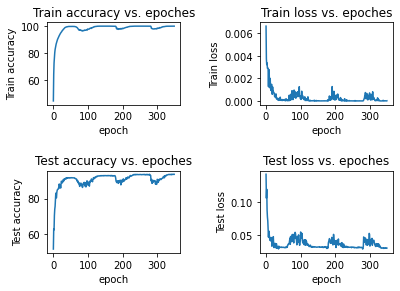

In [8]:
plot_model(train_loss_list,train_acc_list,test_loss_list,test_acc_list)

In [10]:
model_path = './project1_model.pt'
torch.save(net.state_dict(), model_path)